<a href="https://colab.research.google.com/github/3zero69/-/blob/main/%ED%8C%8C%EC%9D%B4%EC%8D%AC_%EB%94%A5%EB%9F%AC%EB%8B%9D_%ED%85%90%EC%84%9C%ED%94%8C%EB%A1%9C_ch4_5_pg_229~240ipynb.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## 07. 이미지 분할
이미지 분할 /세그멘테이션 : 모든 이미지를 구성하는 모든 픽셀에 대해 픽셀 단위로 분류하는 것
1. 의미 분할: 같은 범주의 여러 객체를 하나의 범주로 묶어서 구분
2. 인스턴스 분할: 같은 범주에 속하더라도 서로 다른 객체를 구분

- 배경 클래스와 객체 클래스로 구성된 이지미의 경우, 모든 픽셀은 배경 또는 객체 중 하나로 분류됨.
  - 모든 픽셀에 대한 정답 클래스를 레이블로 처리한 데이터셋을 가지고 딥러닝 모델을 훈련시키면 정답 클래스를 알지 못하는 새로운 이미지에 대해서도 배경과 객체를 분리할 수 있음

### 07-1. 데이터셋 준비
- class1 : 반려동물이 속한 픽셀 (노란색 영역)
- class2 : 반려동물과 인접한 픽셀 (빨간색 영역)
- class3 : 위에 속하지 않는 경우, 주변 픽셀 (파란색 영역)

In [1]:
import numpy as np
import tensorflow as tf
import matplotlib.pylab as plt
import cv2
from tqdm.notebook import tqdm
import tensorflow_datasets as tfds
from google.colab.patches import cv2_imshow

In [2]:
# 이미지 크기
img_w = 128
img_h = 128
img_c = 3
img_shape = (img_w, img_h, img_c)

# 모델 학습
epoch_num = 5
learning_rate = 0.0001
buffer_size = 1000
batch_size = 16

In [3]:
# 텐서플로 데이터셋 로드
ds_str = 'oxford_iiit_pet'
ds, info = tfds.load(name=ds_str, with_info=True)

Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

Extraction completed...: 0 file [00:00, ? file/s]

Shuffling /root/tensorflow_datasets/oxford_iiit_pet/3.2.0.incompleteQYC3EW/oxford_iiit_pet-train.tfrecord*...:…

Generating test examples...:   0%|          | 0/3669 [00:00<?, ? examples/s]

Shuffling /root/tensorflow_datasets/oxford_iiit_pet/3.2.0.incompleteQYC3EW/oxford_iiit_pet-test.tfrecord*...: …

Dataset oxford_iiit_pet downloaded and prepared to /root/tensorflow_datasets/oxford_iiit_pet/3.2.0. Subsequent calls will reuse this data.


원본 이미지와 분할 마스크를 처리하는 함수 정의
- 이미지 크기 (128,128) 로 변경 및 자료형 변환
- 원본 이미지의 픽셀 정규화 : 255로 나누어 0~1 범위로
- 마스크: 0,1,2 정수형 값을 갖도록 1 차감

In [4]:

# 이미지 전처리 함수
def preprocess_image(ds):
  # 원본 이미지
  img = tf.image.resize(ds['image'],(img_w, img_h))
  img = tf.cast(img, tf.float32) / 255.0
  # 분할 마스크
  mask = tf.image.resize(ds['segmentation_mask'],(img_w, img_h))
  mask = tf.cast(mask, tf.int32)
  mask = mask - 1
  return img, mask


전처리 함수를 훈련/ 테스트 셋에 매핑 후, 미니배치로 분할

In [5]:
# 데이터 전처리 파이프라인
train_ds = ds['train'].map(preprocess_image).shuffle(buffer_size).batch(batch_size).prefetch(2)
test_ds = ds['test'].map(preprocess_image).shuffle(buffer_size).batch(batch_size).prefetch(2)

print(train_ds)

<_PrefetchDataset element_spec=(TensorSpec(shape=(None, 128, 128, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None, 128, 128, 1), dtype=tf.int32, name=None))>


In [6]:
# 샘플 배치 선택
img, mask = next(iter(train_ds))
len(img)

16

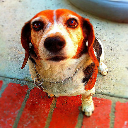

In [7]:
# 샘플 이미지 출력
img = np.array(img[0]) * 255.0  ## 255를 곱해 정규화 이전의 원래 값으로 복원
img = cv2.cvtColor(img, cv2.COLOR_RGB2BGR)
cv2_imshow(img)

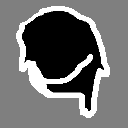

In [8]:
# 샘플 마스크 출력
mask = (np.array(mask[0])/2)*255.0
cv2_imshow(mask)

### 07-2. U-Net 모델 (인코더-디코더)
사전 학습된 VGG16 모델을 인코더로 활용하는 U-Net 모델 생성
- 사전 학습된 모델을 이용하여 학습 진행
  - 데이터 개수가 충분하지 않을 경우
  - 학습 시간 절약

**VGG16 모델**
합성곱 층과 풀링 층을 직렬로 연결한 구조
- 인코더는 원본 이미지 중에서 같은 범주에 속하는 픽셀을 결합하면서 점진적으로 이미지를 더 작은 크기로 축소
  - 마스크 정답을 활용하여 각 픽셀의 마스크 범주를 0,1,2 중 하나로 분류하는 역할

In [9]:
# VGG16 모델
base_model = tf.keras.applications.VGG16(input_shape=img_shape, include_top=False)

58889256/58889256 [==============================] - 0s 0us/step


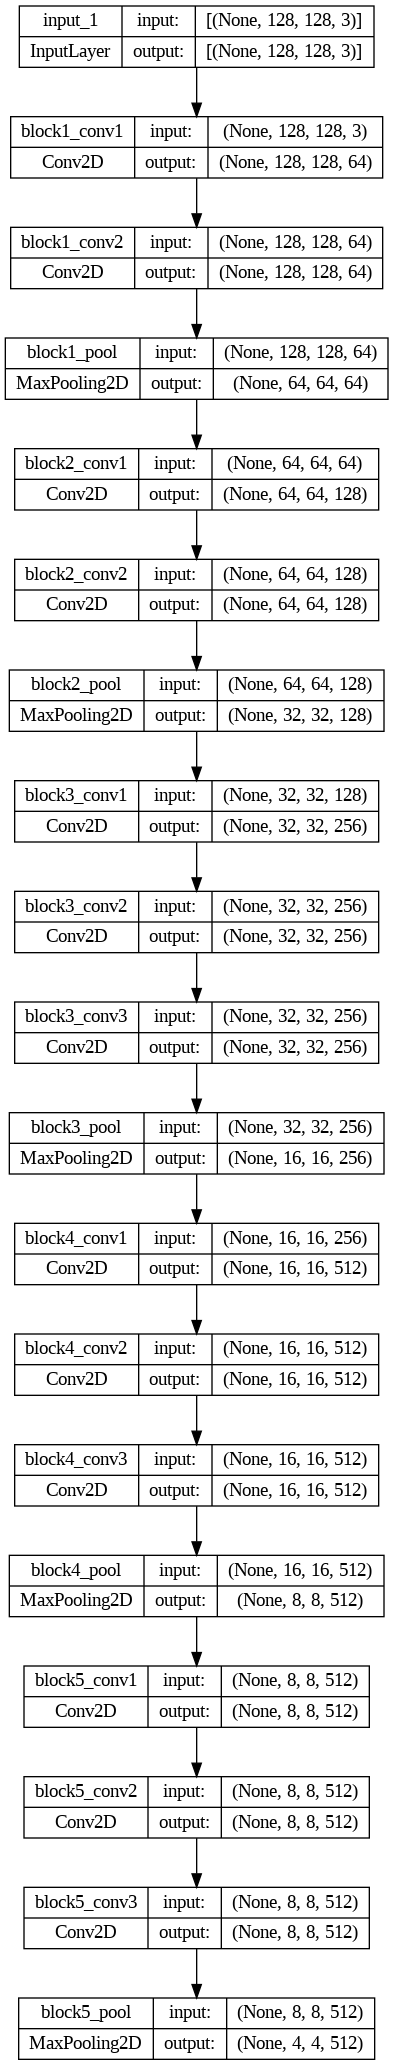

In [10]:
# 모델 구조
tf.keras.utils.plot_model(base_model, show_shapes=True)

In [11]:
# VGG16 중간 레이어 출력 텐서를 지정

f_model = tf.keras.Model(inputs=[base_model.input],
                         outputs=[
                                  base_model.get_layer(name='block5_conv3').output,
                                  base_model.get_layer(name='block4_conv3').output,
                                  base_model.get_layer(name='block3_conv3').output,
                                  base_model.get_layer(name='block2_conv2').output,
                                  base_model.get_layer(name='block1_conv2').output,
                         ])

# 파라미터 고정 - 사전 학습된 파라미터를 인코더에 그대로 사용하기 위해 업데이트 되지 않도록 고정
f_model.trainable = False

인코더 부분에서 5개의 출력을 가져와 디코더의 입력으로 전달
- 업샘플링 : 축소된 이미지를 원래 이미지의 크기로 복원하는 과정

In [12]:
# U-Net 구조로 모델 정의

i = tf.keras.Input(shape=img_shape)

out_8_8_512, out_16_16_512, out_32_32_256, out_64_64_128, out_128_128_64 = f_model(i)

out = tf.keras.layers.Conv2DTranspose(512, 3, strides=2, padding='same')(out_8_8_512)
out = tf.keras.layers.Add()([out, out_16_16_512])

out = tf.keras.layers.Conv2DTranspose(256, 3, strides=2, padding='same')(out)
out = tf.keras.layers.Add()([out, out_32_32_256])

out = tf.keras.layers.Conv2DTranspose(128, 3, strides=2, padding='same')(out)
out = tf.keras.layers.Add()([out, out_64_64_128])

out = tf.keras.layers.Conv2DTranspose(64, 3, strides=2, padding='same')(out)
out = tf.keras.layers.Add()([out, out_128_128_64])

out = tf.keras.layers.Conv2D(3, 3, activation='elu', padding='same')(out)
out = tf.keras.layers.Dense(3, activation='softmax')(out)

unet_model = tf.keras.Model(inputs=[i], outputs=[out])

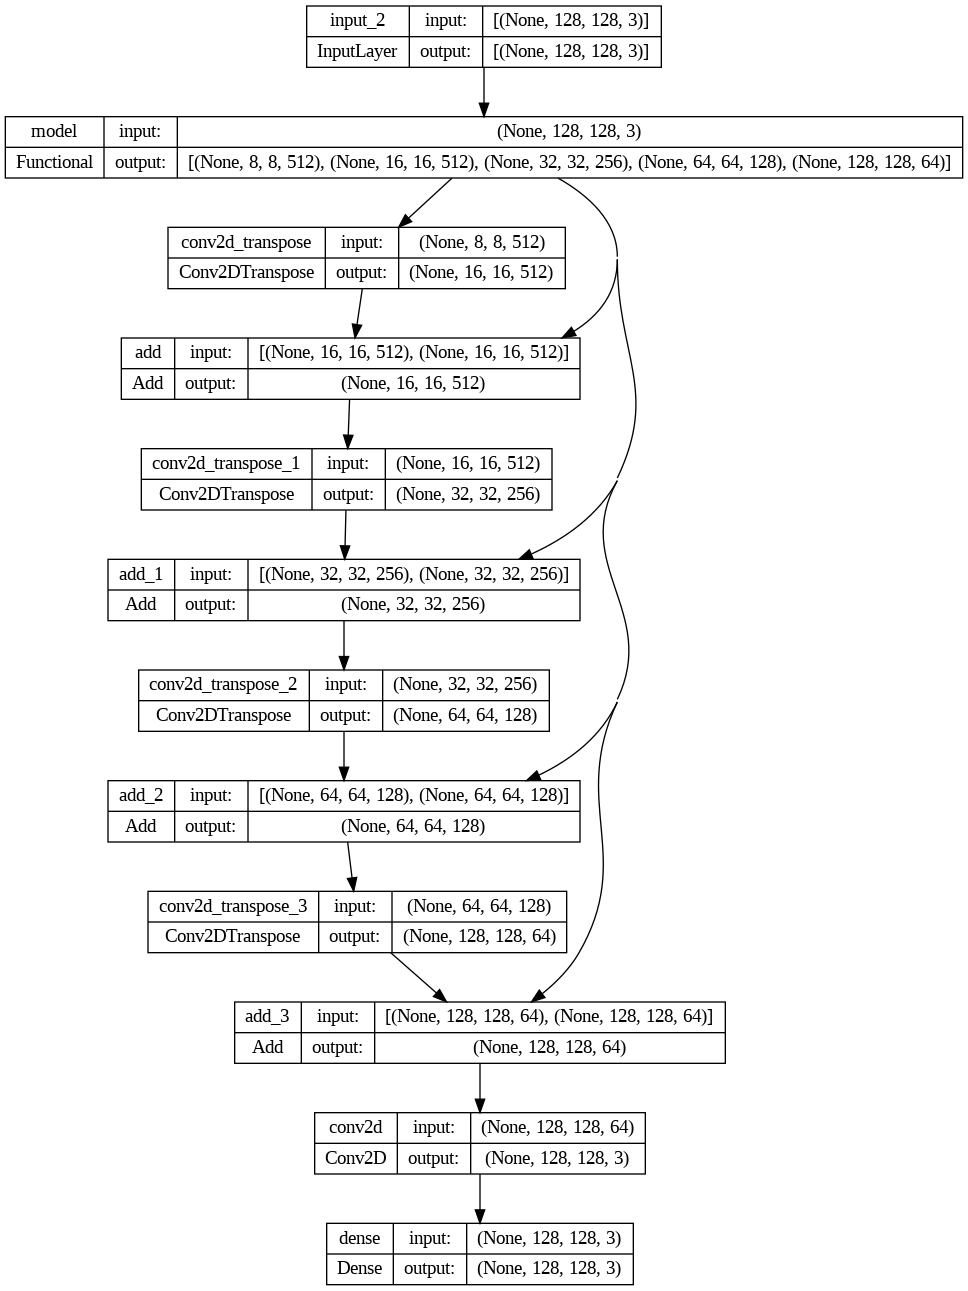

In [13]:
# 모델 구조 시각화
tf.keras.utils.plot_model(unet_model, show_shapes=True)

In [14]:
# 모델 요약
unet_model.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 128, 128, 3  0           []                               
                                )]                                                                
                                                                                                  
 model (Functional)             [(None, 8, 8, 512),  14714688    ['input_2[0][0]']                
                                 (None, 16, 16, 512                                               
                                ),                                                                
                                 (None, 32, 32, 256                                               
                                ),                                                          

In [ ]:
# 모델 컴파일 및 훈련
loss_f = tf.losses.SparseCategoricalCrossentropy()
opt = tf.optimizers.Adam(learning_rate)

unet_model.compile(optimizer=opt, loss=loss_f, metrics=['accuracy'])
unet_model.fit(train_ds, batch_size=batch_size, epochs=epoch_num)

Epoch 1/5
230/230 [==============================] - 1563s 7s/step - loss: 0.9155 - accuracy: 0.7042
Epoch 2/5
230/230 [==============================] - 1658s 7s/step - loss: 0.5320 - accuracy: 0.8221
Epoch 3/5
230/230 [==============================] - 1541s 7s/step - loss: 0.4680 - accuracy: 0.8393
Epoch 4/5
 67/230 [=======>......................] - ETA: 18:10 - loss: 0.4564 - accuracy: 0.8421

In [ ]:
# 1개 배치(16개 이미지)를 선택
img, mask = next(iter(test_ds))

# 모델 예측
pred = unet_model.predict(img)

# 첫 번째 이미지 분할 결과를 출력
pred_img = np.argmax(pred[0], -1)
plt.imshow(pred_img)

In [ ]:
# 첫 번쨰 이미지의 정답 마스크 출력
plt.imshow(np.reshape(mask[0],(128,128))